# Ungraded Lab: Predicting Sunspots with Neural Networks

In the remaining labs for this week, you will move away from synthetic time series and start building models for real world data. In particular, you will train on the [Sunspots](https://www.kaggle.com/datasets/robervalt/sunspots) dataset: a monthly record of sunspot numbers from January 1749 to July 2018. You will first build a deep neural network here composed of dense layers. This will act as your baseline so you can compare it to the next lab where you will use a more complex architecture.

Let's begin!

## Imports

You will use the same imports as before with the addition of the [csv](https://docs.python.org/3/library/csv.html) module. You will need this to parse the CSV file containing the dataset.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

2024-10-04 18:47:52.107815: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 18:47:52.110925: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 18:47:52.149315: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 18:47:52.936949: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Utilities

You will only have the `plot_series()` dataset here because you no longer need the synthetic data generation functions.

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

You can now download the dataset and inspect the contents. The link in class is from Laurence's repo but we also hosted it in the link below.

In [3]:
# Download the dataset
# !wget -nc https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

Running the cell below, you'll see that there are only three columns in the dataset:
1. untitled column containing the month number
2. Date which has the format `YYYY-MM-DD`
3. Mean Total Sunspot Number

In [4]:
# Preview the dataset
!head Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


For this lab and the next, you will only need the month number and the mean total sunspot number. You will load those into memory and convert it to arrays that represents a time series.

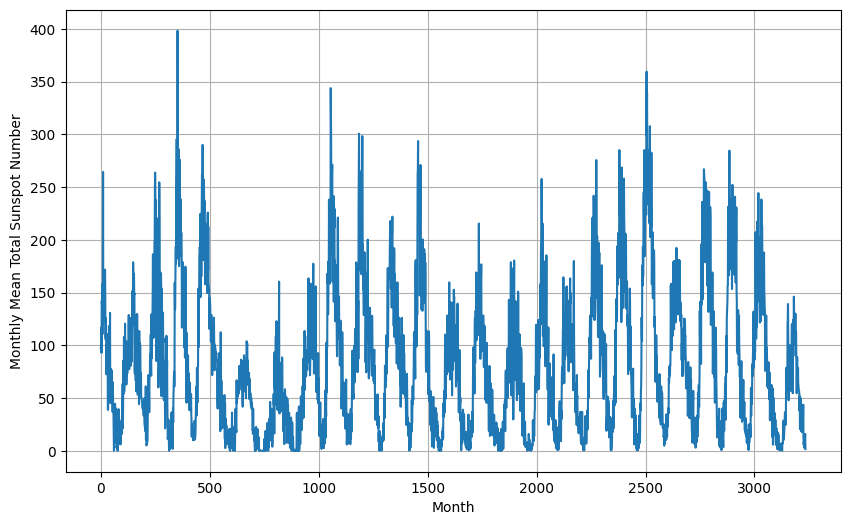

In [5]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

## Split the Dataset

Next, you will split the dataset into training and validation sets. There are 3235 points in the dataset and you will use the first 3000 for training.

In [6]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

You can then prepare the dataset windows as before. The window size is set to 30 points (equal to 2.5 years) but feel free to change later on if you want to experiment.

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

In [8]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

The model will be 3-layer dense network as shown below.

In [9]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(30, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,251 (4.89 KB)

 Trainable params: 1,251 (4.89 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

You can pick a learning rate by running the same learning rate scheduler code from previous labs.

In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 109.1424 - learning_rate: 1.0000e-08
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 107.8810 - learning_rate: 1.1220e-08
Epoch 3/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 105.4311

2024-10-04 18:47:55.612851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/osboxes/anaconda3/envs/tf/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-04 18:47:55.731374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 106.4316 - learning_rate: 1.2589e-08
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 104.8121 - learning_rate: 1.4125e-08
Epoch 5/100
43/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 102.7137

2024-10-04 18:47:55.839888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:55.958319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 103.0009 - learning_rate: 1.5849e-08
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 100.9773 - learning_rate: 1.7783e-08
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 98.7267 - learning_rate: 1.9953e-08
Epoch 8/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 84.9840

2024-10-04 18:47:56.070120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:56.156561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:56.243071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 96.2212 - learning_rate: 2.2387e-08
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 93.4313 - learning_rate: 2.5119e-08
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 90.3186 - learning_rate: 2.8184e-08
Epoch 11/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 77.5773

2024-10-04 18:47:56.344200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:56.429218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:56.516391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 86.8618 - learning_rate: 3.1623e-08
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 83.0489 - learning_rate: 3.5481e-08
Epoch 13/100
60/93 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 78.4462

2024-10-04 18:47:56.606536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:56.735185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 78.8791 - learning_rate: 3.9811e-08
Epoch 14/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74.3856 - learning_rate: 4.4668e-08
Epoch 15/100
46/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69.8820

2024-10-04 18:47:56.829493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:56.932806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69.5803 - learning_rate: 5.0119e-08
Epoch 16/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 64.5584 - learning_rate: 5.6234e-08
Epoch 17/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55.0683

2024-10-04 18:47:57.053705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:57.224804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.5979 - learning_rate: 6.3096e-08
Epoch 18/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 54.7667 - learning_rate: 7.0795e-08
Epoch 19/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 50.2813 - learning_rate: 7.9433e-08
Epoch 20/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 42.2127

2024-10-04 18:47:57.323874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:57.412977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:57.510937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46.4563 - learning_rate: 8.9125e-08
Epoch 21/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 43.4602 - learning_rate: 1.0000e-07
Epoch 22/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 41.0251 - learning_rate: 1.1220e-07
Epoch 23/100


2024-10-04 18:47:57.613239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:57.712653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:57.809298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39.0442 - learning_rate: 1.2589e-07
Epoch 24/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 37.4260 - learning_rate: 1.4125e-07
Epoch 25/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 36.0187 - learning_rate: 1.5849e-07
Epoch 26/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 32.4184

2024-10-04 18:47:57.917260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:58.008034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:58.108785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 34.6765 - learning_rate: 1.7783e-07
Epoch 27/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 33.3784 - learning_rate: 1.9953e-07
Epoch 28/100
55/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.6480

2024-10-04 18:47:58.206717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:58.296862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.0707 - learning_rate: 2.2387e-07
Epoch 29/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 30.7637 - learning_rate: 2.5119e-07
Epoch 30/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 29.5239 - learning_rate: 2.8184e-07
Epoch 31/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.3718

2024-10-04 18:47:58.443967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:58.541635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:58.636702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28.4225 - learning_rate: 3.1623e-07
Epoch 32/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.4353 - learning_rate: 3.5481e-07
Epoch 33/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26.3862

2024-10-04 18:47:58.761495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:58.886732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26.6246 - learning_rate: 3.9811e-07
Epoch 34/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25.9415 - learning_rate: 4.4668e-07
Epoch 35/100
47/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25.2264

2024-10-04 18:47:59.000687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:59.111446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25.3769 - learning_rate: 5.0119e-07
Epoch 36/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24.8921 - learning_rate: 5.6234e-07
Epoch 37/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 24.4766 - learning_rate: 6.3096e-07


2024-10-04 18:47:59.211935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:59.322194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:59.410535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 38/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 24.1146 - learning_rate: 7.0795e-07
Epoch 39/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 23.7464 - learning_rate: 7.9433e-07
Epoch 40/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 23.3724 - learning_rate: 8.9125e-07
Epoch 41/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.9817

2024-10-04 18:47:59.505802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:59.600421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:59.691895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 22.9833 - learning_rate: 1.0000e-06
Epoch 42/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 22.5741 - learning_rate: 1.1220e-06
Epoch 43/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 22.2173 - learning_rate: 1.2589e-06
Epoch 44/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.2853

2024-10-04 18:47:59.787448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:59.879828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:47:59.973673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.8833 - learning_rate: 1.4125e-06
Epoch 45/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 21.6132 - learning_rate: 1.5849e-06
Epoch 46/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 21.3603 - learning_rate: 1.7783e-06
Epoch 47/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 19.9182

2024-10-04 18:48:00.084429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:00.172202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:00.259384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.1281 - learning_rate: 1.9953e-06
Epoch 48/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 20.8914 - learning_rate: 2.2387e-06
Epoch 49/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 20.6663 - learning_rate: 2.5119e-06
Epoch 50/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.1671

2024-10-04 18:48:00.402846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:00.491314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:00.586583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 20.4661 - learning_rate: 2.8184e-06
Epoch 51/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 20.2585 - learning_rate: 3.1623e-06
Epoch 52/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 20.0478 - learning_rate: 3.5481e-06
Epoch 53/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.7715

2024-10-04 18:48:00.672961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:00.761418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:00.849093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 19.8151 - learning_rate: 3.9811e-06
Epoch 54/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.5678 - learning_rate: 4.4668e-06
Epoch 55/100
47/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.4655

2024-10-04 18:48:00.942169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:01.049434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.3351 - learning_rate: 5.0119e-06
Epoch 56/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.1392 - learning_rate: 5.6234e-06
Epoch 57/100
46/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.1023

2024-10-04 18:48:01.170328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:01.291159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.9739 - learning_rate: 6.3096e-06
Epoch 58/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.7886 - learning_rate: 7.0795e-06
Epoch 59/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 18.6545 - learning_rate: 7.9433e-06


2024-10-04 18:48:01.405295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:01.512205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:01.605104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 60/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.5141 - learning_rate: 8.9125e-06
Epoch 61/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 18.3887 - learning_rate: 1.0000e-05
Epoch 62/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 18.2427 - learning_rate: 1.1220e-05
Epoch 63/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.8529

2024-10-04 18:48:01.707553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:01.798579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:01.893569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.1106 - learning_rate: 1.2589e-05
Epoch 64/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.9272 - learning_rate: 1.4125e-05
Epoch 65/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.0696

2024-10-04 18:48:01.991405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:02.104890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.7980 - learning_rate: 1.5849e-05
Epoch 66/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.7161 - learning_rate: 1.7783e-05
Epoch 67/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 17.6888 - learning_rate: 1.9953e-05
Epoch 68/100


2024-10-04 18:48:02.275347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:02.379326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:02.471310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.5754 - learning_rate: 2.2387e-05
Epoch 69/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 17.5386 - learning_rate: 2.5119e-05
Epoch 70/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 17.4897 - learning_rate: 2.8184e-05
Epoch 71/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14.2351

2024-10-04 18:48:02.572776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:02.662137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:02.759160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.5699 - learning_rate: 3.1623e-05
Epoch 72/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 17.4222 - learning_rate: 3.5481e-05
Epoch 73/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 17.5044 - learning_rate: 3.9811e-05
Epoch 74/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.8005

2024-10-04 18:48:02.861849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:02.949376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:03.041079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 17.4817 - learning_rate: 4.4668e-05
Epoch 75/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 17.5253 - learning_rate: 5.0119e-05
Epoch 76/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 17.4542 - learning_rate: 5.6234e-05
Epoch 77/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.6349

2024-10-04 18:48:03.133473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:03.221425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:03.316092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 17.4135 - learning_rate: 6.3096e-05
Epoch 78/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 17.3563 - learning_rate: 7.0795e-05
Epoch 79/100
55/93 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 17.1639

2024-10-04 18:48:03.409690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:03.507089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.1761 - learning_rate: 7.9433e-05
Epoch 80/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 17.2754 - learning_rate: 8.9125e-05
Epoch 81/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 17.3415 - learning_rate: 1.0000e-04
Epoch 82/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.7606

2024-10-04 18:48:03.614850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:03.706707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:03.798282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.3044 - learning_rate: 1.1220e-04
Epoch 83/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 17.9014 - learning_rate: 1.2589e-04
Epoch 84/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 18.2230 - learning_rate: 1.4125e-04
Epoch 85/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.4369

2024-10-04 18:48:03.919569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:04.007200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:04.092220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 17.7169 - learning_rate: 1.5849e-04
Epoch 86/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 18.0975 - learning_rate: 1.7783e-04
Epoch 87/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 17.9703 - learning_rate: 1.9953e-04
Epoch 88/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.3690

2024-10-04 18:48:04.185401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:04.274063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:04.358724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 17.8069 - learning_rate: 2.2387e-04
Epoch 89/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 19.0316 - learning_rate: 2.5119e-04
Epoch 90/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 18.9955 - learning_rate: 2.8184e-04
Epoch 91/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.4284

2024-10-04 18:48:04.449614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:04.538842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:04.632176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.3296 - learning_rate: 3.1623e-04
Epoch 92/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 19.4508 - learning_rate: 3.5481e-04
Epoch 93/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 19.5242 - learning_rate: 3.9811e-04
Epoch 94/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.2362

2024-10-04 18:48:04.731991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:04.824221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:04.916869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 20.4603 - learning_rate: 4.4668e-04
Epoch 95/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 20.1125 - learning_rate: 5.0119e-04
Epoch 96/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.6080 - learning_rate: 5.6234e-04
Epoch 97/100


2024-10-04 18:48:05.009307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:05.099096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:05.205991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.8347 - learning_rate: 6.3096e-04
Epoch 98/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.2814 - learning_rate: 7.0795e-04
Epoch 99/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 24.0633 - learning_rate: 7.9433e-04


2024-10-04 18:48:05.320350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:05.429475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:05.519067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 100/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26.6082 - learning_rate: 8.9125e-04


2024-10-04 18:48:05.665840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


(1e-08, 0.001, 0.0, 100.0)

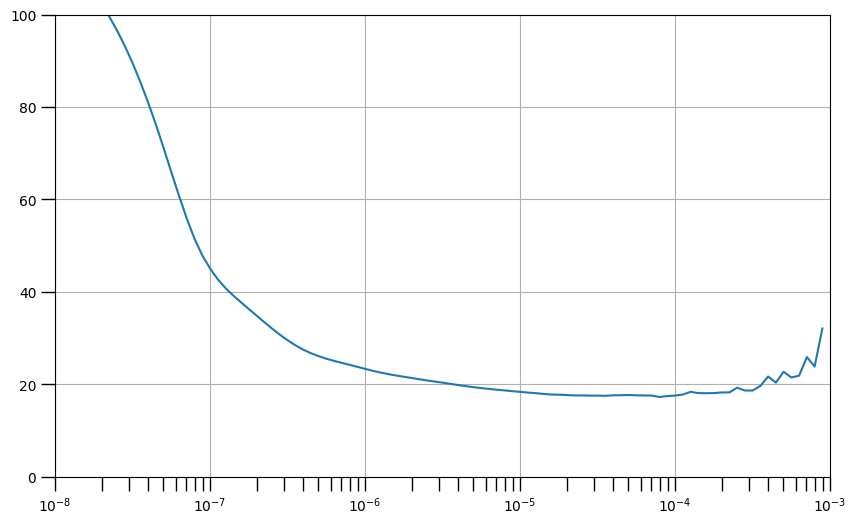

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train the Model

Once you've picked a learning rate, you can rebuild the model and start training.

In [12]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(30, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [13]:
# Set the learning rate
learning_rate = 2e-5

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 110.7779 - mae: 111.2754
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 20.3516 - mae: 20.8447
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 19.1649 - mae: 19.6544
Epoch 4/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.1850 - mae: 16.6660

2024-10-04 18:48:06.929487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:07.023106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:07.117342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 18.8215 - mae: 19.3137
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 18.4954 - mae: 18.9885
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 18.2596 - mae: 18.7503
Epoch 7/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.1972 - mae: 15.6892

2024-10-04 18:48:07.209018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:07.302400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:07.391242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.1442 - mae: 18.6369
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.1344 - mae: 18.6267
Epoch 9/100
37/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.2118 - mae: 18.7034

2024-10-04 18:48:07.505768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:07.627677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.9921 - mae: 18.4843
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 17.8912 - mae: 18.3826
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 17.8347 - mae: 18.3258
Epoch 12/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.7892 - mae: 15.2848

2024-10-04 18:48:07.813945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:07.910363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:08.004362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 17.8086 - mae: 18.3017
Epoch 13/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 17.7237 - mae: 18.2149
Epoch 14/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 17.6479 - mae: 18.1396
Epoch 15/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.8221 - mae: 14.2945

2024-10-04 18:48:08.096292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:08.187745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:08.276282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 17.5778 - mae: 18.0682
Epoch 16/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 17.5411 - mae: 18.0268
Epoch 17/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 17.5151 - mae: 18.0010
Epoch 18/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.6796 - mae: 14.1376

2024-10-04 18:48:08.369190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:08.457818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:08.547647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 17.4612 - mae: 17.9467
Epoch 19/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 17.4197 - mae: 17.9053
Epoch 20/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 17.3734 - mae: 17.8616
Epoch 21/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.6902 - mae: 14.1490

2024-10-04 18:48:08.643770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:08.739849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:08.831782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.3482 - mae: 17.8367
Epoch 22/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.3362 - mae: 17.8249  
Epoch 23/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 17.3131 - mae: 17.8019


2024-10-04 18:48:08.937617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:09.036674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:09.133988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 24/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 17.2912 - mae: 17.7786
Epoch 25/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2639 - mae: 17.7516
Epoch 26/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 17.2078 - mae: 17.6960

2024-10-04 18:48:09.230143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:09.343563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2285 - mae: 17.7171  
Epoch 27/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2091 - mae: 17.6971
Epoch 28/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.4942 - mae: 13.9768

2024-10-04 18:48:09.441974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:09.602329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 17.1966 - mae: 17.6847
Epoch 29/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 17.1816 - mae: 17.6698
Epoch 30/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 17.1738 - mae: 17.6625
Epoch 31/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.5755 - mae: 14.0686

2024-10-04 18:48:09.699765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:09.793085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:09.887981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 17.1480 - mae: 17.6371
Epoch 32/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 17.1196 - mae: 17.6082
Epoch 33/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 17.0917 - mae: 17.5800
Epoch 34/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.6341 - mae: 14.1008

2024-10-04 18:48:09.986560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:10.077121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:10.171756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.0867 - mae: 17.5740
Epoch 35/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 17.0851 - mae: 17.5726
Epoch 36/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 17.0621 - mae: 17.5503
Epoch 37/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.7665 - mae: 14.2402

2024-10-04 18:48:10.273402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:10.369392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:10.463005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.0534 - mae: 17.5422  
Epoch 38/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.0459 - mae: 17.5348
Epoch 39/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 13.8043 - mae: 14.2880

2024-10-04 18:48:10.561416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:10.671916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.0400 - mae: 17.5293
Epoch 40/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 17.0302 - mae: 17.5179
Epoch 41/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 16.9969 - mae: 17.4859
Epoch 42/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.8665 - mae: 14.3352

2024-10-04 18:48:10.842010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:10.933491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:11.027733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.0082 - mae: 17.4945
Epoch 43/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 16.9856 - mae: 17.4723
Epoch 44/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 16.9724 - mae: 17.4620
Epoch 45/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.8588 - mae: 14.3456

2024-10-04 18:48:11.130412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:11.223404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:11.315854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.9606 - mae: 17.4482
Epoch 46/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 16.9592 - mae: 17.4477
Epoch 47/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 16.9436 - mae: 17.4322
Epoch 48/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.8974 - mae: 14.3802

2024-10-04 18:48:11.469489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:11.556492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:11.647950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 16.9465 - mae: 17.4349
Epoch 49/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 16.9555 - mae: 17.4442
Epoch 50/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 16.9408 - mae: 17.4292
Epoch 51/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.9473 - mae: 14.4300

2024-10-04 18:48:11.740382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:11.836548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:11.933079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 16.9384 - mae: 17.4268
Epoch 52/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 16.9285 - mae: 17.4170
Epoch 53/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 16.9252 - mae: 17.4133
Epoch 54/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.9308 - mae: 14.4110

2024-10-04 18:48:12.025568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:12.120627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:12.213218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.9183 - mae: 17.4062
Epoch 55/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.9087 - mae: 17.3965  
Epoch 56/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 16.9075 - mae: 17.3959
Epoch 57/100


2024-10-04 18:48:12.314285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:12.413671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:12.510009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 16.9030 - mae: 17.3910
Epoch 58/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 16.9010 - mae: 17.3885
Epoch 59/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 16.8979 - mae: 17.3851
Epoch 60/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.9425 - mae: 14.4189

2024-10-04 18:48:12.605792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:12.699017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:12.791819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 16.8920 - mae: 17.3787
Epoch 61/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 16.8905 - mae: 17.3766
Epoch 62/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 16.8825 - mae: 17.3680
Epoch 63/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.9736 - mae: 14.4498

2024-10-04 18:48:12.887565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:12.977788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:13.072020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 16.8848 - mae: 17.3704
Epoch 64/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 16.8784 - mae: 17.3636
Epoch 65/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.1983 - mae: 17.6814

2024-10-04 18:48:13.166633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:13.261486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.8859 - mae: 17.3722
Epoch 66/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 16.8815 - mae: 17.3678
Epoch 67/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 16.8793 - mae: 17.3650
Epoch 68/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.0185 - mae: 14.4945

2024-10-04 18:48:13.410961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:13.499713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:13.588357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 16.8741 - mae: 17.3606
Epoch 69/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 16.8734 - mae: 17.3605
Epoch 70/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 16.8820 - mae: 17.3696
Epoch 71/100


2024-10-04 18:48:13.683221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:13.774142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:13.862916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8733 - mae: 17.3605
Epoch 72/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8720 - mae: 17.3594  
Epoch 73/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 16.8675 - mae: 17.3550
Epoch 74/100


2024-10-04 18:48:14.049349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:14.147481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:14.243238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 16.8633 - mae: 17.3507
Epoch 75/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 16.8731 - mae: 17.3597
Epoch 76/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 16.8585 - mae: 17.3448
Epoch 77/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.0085 - mae: 14.4814

2024-10-04 18:48:14.340424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:14.435421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:14.530188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 16.8488 - mae: 17.3355
Epoch 78/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 16.8404 - mae: 17.3262
Epoch 79/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 16.8355 - mae: 17.3231
Epoch 80/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.9948 - mae: 14.4566

2024-10-04 18:48:14.620146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:14.712170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:14.806371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8373 - mae: 17.3232
Epoch 81/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 16.8679 - mae: 17.3535
Epoch 82/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 16.8153 - mae: 17.3020
Epoch 83/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.9498 - mae: 14.4140

2024-10-04 18:48:14.909771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:15.004445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:15.093458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.8281 - mae: 17.3155
Epoch 84/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 16.8141 - mae: 17.3012
Epoch 85/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 16.8429 - mae: 17.3296
Epoch 86/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.9300 - mae: 14.3992

2024-10-04 18:48:15.247610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:15.339216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:15.430530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8363 - mae: 17.3226
Epoch 87/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 16.8360 - mae: 17.3213
Epoch 88/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 16.8479 - mae: 17.3326

2024-10-04 18:48:15.529221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:15.623422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8294 - mae: 17.3149 
Epoch 89/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 16.8376 - mae: 17.3227
Epoch 90/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 16.8375 - mae: 17.3231
Epoch 91/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.9366 - mae: 14.4090

2024-10-04 18:48:15.749804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:15.843640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:15.940246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8341 - mae: 17.3200
Epoch 92/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 16.8321 - mae: 17.3179
Epoch 93/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8300 - mae: 17.3165  
Epoch 94/100


2024-10-04 18:48:16.039182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:16.134572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:16.232296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8276 - mae: 17.3143
Epoch 95/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 16.8246 - mae: 17.3116
Epoch 96/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 16.8162 - mae: 17.3033
Epoch 97/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.8688 - mae: 14.3467

2024-10-04 18:48:16.353394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:16.441391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:16.535863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 16.8132 - mae: 17.3006
Epoch 98/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 16.7974 - mae: 17.2845
Epoch 99/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 16.7824 - mae: 17.2716
Epoch 100/100


2024-10-04 18:48:16.626084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:16.721019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 18:48:16.810711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7828 - mae: 17.2686


2024-10-04 18:48:16.955195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


## Model Prediction

Now see if the model generates good results. If you used the default parameters of this notebook, you should see the predictions follow the shape of the ground truth with an MAE of around 15. 

In [14]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)
    
    return forecast

2024-10-04 18:48:17.089648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


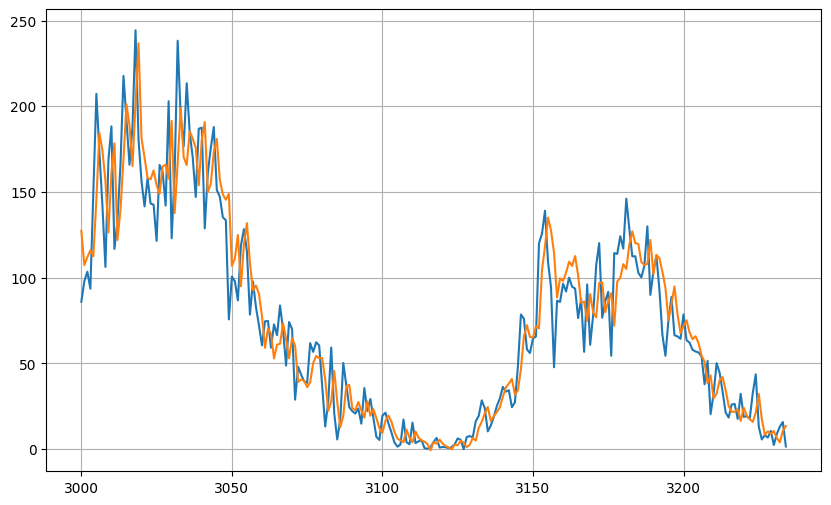

In [15]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [16]:
# Compute the MAE
print(tf.keras.metrics.mae(x_valid, results).numpy())

15.14351


## Wrap Up

In this lab, you built a relatively simple DNN to forecast sunspot numbers for a given month. We encourage you to tweak the parameters or train longer and see the best results you can get. In the next lab, you will build a more complex model and you evaluate if the added complexity translates to better or worse results.